In [8]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import umap
import matplotlib.pyplot as plt

from matplotlib.backends.backend_agg import FigureCanvasAgg
from matplotlib.figure import Figure


In [9]:
def compute_diversity(dataset):
    """
    dataset: np.array shape (N, d)
    return: float - độ đa dạng của dataset
    Ở đây, ta ví dụ tính trung bình phương sai các chiều
    """
    if len(dataset) == 0:
        return 0.0
    # shape = (N, d)
    variances = np.var(dataset, axis=0)
    diversity_score = np.mean(variances)
    return float(diversity_score)


In [10]:
def reconstruct_data_from_z(z_prime, n_samples=100):
    """
    z_prime: torch.Tensor shape (batch_size, z_dim)
    Trả về np.array shape (batch_size, n_samples, data_dim)
    mỗi item tương ứng 1 "batch data" tái dựng từ z'
    
    Ví dụ toy:
      - coi z' = mean, generate random ~ N(z', I)
      - data_dim = z_dim (cho gọn)
    """
    z_prime_np = z_prime.detach().cpu().numpy()  # (batch_size, z_dim)
    batch_size, z_dim = z_prime_np.shape

    # Kết quả dataset giả = random normal quanh z'
    # => shape (batch_size, n_samples, z_dim)
    reconstructed_list = []
    for i in range(batch_size):
        mean_i = z_prime_np[i]  # shape (z_dim,)
        # generate n_samples data_dim=z_dim
        data_i = np.random.normal(loc=mean_i, scale=1.0, size=(n_samples, z_dim))
        reconstructed_list.append(data_i)
    reconstructed_data = np.stack(reconstructed_list, axis=0)
    return reconstructed_data


In [15]:
def dataset_to_image_via_umap(dataset, reducer, img_size=(64, 64)):
    """
    dataset: np.array shape (N, d)
    reducer: 1 model UMAP đã fit
    img_size: (height, width)
    
    Return: torch.Tensor shape (1, height, width) - grayscale
    (hoặc (3, height, width) nếu muốn RGB)
    """
    if len(dataset) == 0:
        # Trả về ảnh đen
        return torch.zeros((1, img_size[0], img_size[1]))
    
    # Giảm chiều
    embedded = reducer.transform(dataset)  # shape (N, 2)
    
    # Vẽ scatter => convert to image
    fig = Figure(figsize=(2, 2), dpi=32)  # nhỏ thôi => 64x64
    canvas = FigureCanvasAgg(fig)
    ax = fig.gca()
    ax.scatter(embedded[:,0], embedded[:,1], s=2, c='blue', alpha=0.5)
    ax.set_xticks([])
    ax.set_yticks([])
    fig.tight_layout()
    
    canvas.draw()
    rgba = np.asarray(canvas.buffer_rgba())  # shape (H, W, 4)
    plt.close(fig)
    
    # Chuyển sang grayscale cho đơn giản
    rgb = rgba[..., :3]  # (H, W, 3)
    gray = np.mean(rgb, axis=-1)  # (H, W)
    
    # Resize (nếu cần) -> 64x64
    from PIL import Image
    pil_img = Image.fromarray(gray.astype(np.uint8))
    pil_img = pil_img.resize(img_size, Image.Resampling.LANCZOS)

    gray_resized = np.array(pil_img)  # shape (64, 64)
    
    # Đưa về tensor [1, H, W]
    tensor_img = torch.from_numpy(gray_resized).unsqueeze(0).float() / 255.0
    return tensor_img


In [16]:
class CNNEncoder(nn.Module):
    """
    Mạng CNN đơn giản để trích xuất ảnh 64x64 -> embedding
    """
    def __init__(self, out_dim=64):
        super(CNNEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=4, stride=2, padding=1)   # 1 -> 8
        self.conv2 = nn.Conv2d(8, 16, kernel_size=4, stride=2, padding=1) # 8 -> 16
        self.conv3 = nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1) # 16->32
        self.fc = nn.Linear(32*8*8, out_dim)  # 64x64 -> (3 downsample) => 8x8

    def forward(self, x):
        # x shape: (batch_size, 1, 64, 64)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        # flatten
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

class ZEncoder(nn.Module):
    """
    Mạng MLP nhỏ để nhúng z -> 1 embedding
    """
    def __init__(self, z_dim, out_dim=32):
        super(ZEncoder, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(z_dim, 64),
            nn.ReLU(),
            nn.Linear(64, out_dim),
            nn.ReLU()
        )
    def forward(self, z):
        return self.mlp(z)

class PolicyNetwork(nn.Module):
    """
    Kết hợp CNNEncoder + ZEncoder => concat => MLP ra z'
    """
    def __init__(self, z_dim):
        super(PolicyNetwork, self).__init__()
        self.cnn_encoder = CNNEncoder(out_dim=64)
        self.z_encoder = ZEncoder(z_dim, out_dim=32)
        
        # Concat 64 + 32 => 96
        self.fc_out = nn.Sequential(
            nn.Linear(96, 64),
            nn.ReLU(),
            nn.Linear(64, z_dim)  # output z' (cùng chiều z)
        )
        
    def forward(self, image, z):
        """
        image shape: (batch_size, 1, 64, 64)
        z shape: (batch_size, z_dim)
        return: z' shape (batch_size, z_dim)
        """
        emb_img = self.cnn_encoder(image)  # (batch_size, 64)
        emb_z = self.z_encoder(z)          # (batch_size, 32)
        concat = torch.cat([emb_img, emb_z], dim=-1)  # (batch_size, 96)
        z_prime = self.fc_out(concat)  # (batch_size, z_dim)
        return z_prime

class ValueNetwork(nn.Module):
    """
    Ước lượng giá trị (value) của state (ảnh UMAP + z)
    """
    def __init__(self, z_dim):
        super(ValueNetwork, self).__init__()
        self.cnn_encoder = CNNEncoder(out_dim=64)
        self.z_encoder = ZEncoder(z_dim, out_dim=32)
        
        self.fc_out = nn.Sequential(
            nn.Linear(96, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
    def forward(self, image, z):
        emb_img = self.cnn_encoder(image)
        emb_z = self.z_encoder(z)
        concat = torch.cat([emb_img, emb_z], dim=-1)
        val = self.fc_out(concat)
        return val


In [17]:
class PPOTrainer:
    def __init__(self, policy_net, value_net, z_dim,
                 policy_lr=1e-4,
                 value_lr=1e-4,
                 gamma=0.99,
                 clip_epsilon=0.2,
                 device='cpu'):
        self.device = device
        self.policy_net = policy_net.to(device)
        self.value_net = value_net.to(device)
        
        self.policy_optimizer = optim.Adam(self.policy_net.parameters(), lr=policy_lr)
        self.value_optimizer = optim.Adam(self.value_net.parameters(), lr=value_lr)
        
        self.gamma = gamma
        self.clip_epsilon = clip_epsilon
        self.z_dim = z_dim

    def get_log_prob(self, z_prime):
        """
        Minh hoạ: log_prob(action) = -0.5 * ||z'||^2
        Thực tế nên dùng Distribution (vd Normal)
        """
        return -0.5 * torch.sum(z_prime**2, dim=-1, keepdim=True)

    def train_on_batch(self, images, z_vectors, old_log_probs, returns, advantages, n_epochs=4):
        for _ in range(n_epochs):
            new_z_prime = self.policy_net(images, z_vectors)
            new_log_probs = self.get_log_prob(new_z_prime)

            ratio = torch.exp(new_log_probs - old_log_probs)

            adv = advantages.detach()
            obj1 = ratio * adv
            obj2 = torch.clamp(ratio, 1.0 - self.clip_epsilon, 1.0 + self.clip_epsilon) * adv
            policy_loss = -torch.mean(torch.min(obj1, obj2))

            value_pred = self.value_net(images, z_vectors)
            value_loss = F.mse_loss(value_pred, returns)

            total_loss = policy_loss + value_loss

            self.policy_optimizer.zero_grad()
            self.value_optimizer.zero_grad()
            total_loss.backward()
            self.policy_optimizer.step()
            self.value_optimizer.step()

    def step(self, dataset, z_vectors, reducer):
        """
        Thực hiện 1 "step" PPO (giả lập 1 batch):
         - Convert dataset -> ảnh UMAP
         - Policy -> z'
         - Tái dựng z' -> new data => update dataset
         - Tính reward = diversity(new_dataset) - diversity(old_dataset)
        """
        self.policy_net.train()
        self.value_net.train()

        batch_size = z_vectors.shape[0]

        # 1) Convert dataset -> image
        #    Mỗi sample trong batch, ta coi "dataset" như nhau => DEMO
        #    Hoặc bạn có logic chia dataset ra, ...
        #    Ở đây, ta render 1 ảnh => copy batch_size lần
        with torch.no_grad():
            single_image = dataset_to_image_via_umap(dataset, reducer, img_size=(64,64))
            images = single_image.unsqueeze(0).repeat(batch_size,1,1,1).to(self.device)
        
        z_vectors = z_vectors.to(self.device)

        # 2) Policy => z_prime
        with torch.no_grad():
            z_prime = self.policy_net(images, z_vectors)
            old_log_probs = self.get_log_prob(z_prime)
            values = self.value_net(images, z_vectors)

        # 3) Tạo dataset mới = dataset gốc + reconstruct(z_prime)
        #   Ở đây ta xử lý theo batch => ta chỉ tính reward trung bình
        reconstructed_data_batch = reconstruct_data_from_z(z_prime)  # shape (batch_size, n_samples, data_dim)
        
        # Tính reward cho mỗi sample trong batch
        rewards = []
        for i in range(batch_size):
            # dataset cũ: shape (N, d)
            old_div = compute_diversity(dataset)
            # data tái dựng i: shape (n_samples, data_dim)
            new_dataset_i = np.concatenate([dataset, reconstructed_data_batch[i]], axis=0)
            new_div = compute_diversity(new_dataset_i)
            r = new_div - old_div  # reward = độ tăng diversity
            rewards.append(r)
        rewards = torch.tensor(rewards, dtype=torch.float32, device=self.device).unsqueeze(-1)

        # 4) Giả sử next_value ~ value (minh hoạ), done=0 => advantage
        dones = torch.zeros_like(rewards)
        next_values = values
        advantages = rewards + self.gamma*next_values*(1-dones) - values
        returns = values + advantages

        # 5) PPO update
        self.train_on_batch(images, z_vectors, old_log_probs, returns, advantages, n_epochs=4)

        return rewards.mean().item()


D:\Study\Code\SwiftHydra\.venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


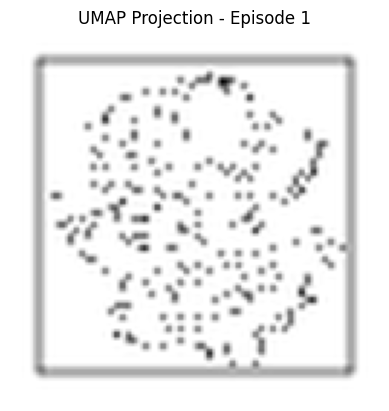

Iteration 1/10, Reward=0.0153, Diversity=0.9541


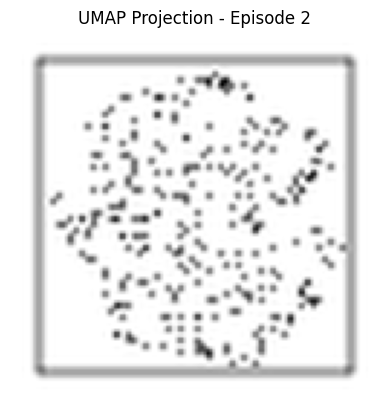

Iteration 2/10, Reward=0.0254, Diversity=0.9461


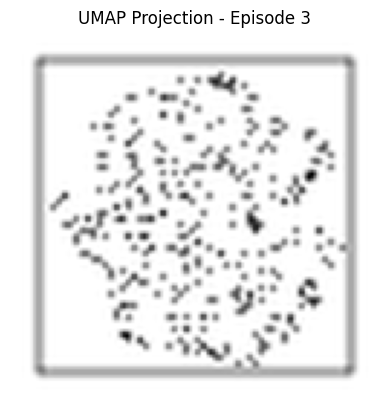

Iteration 3/10, Reward=0.0064, Diversity=0.9805


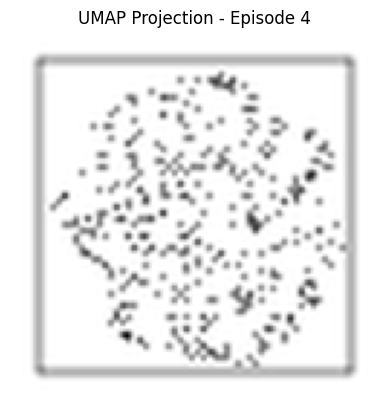

Iteration 4/10, Reward=0.0087, Diversity=0.9768


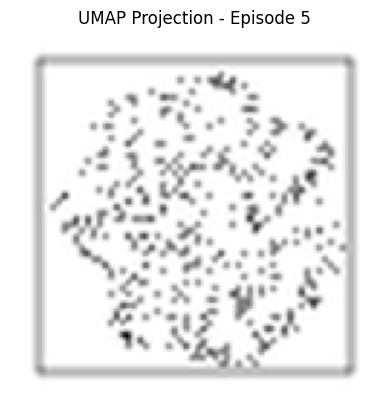

Iteration 5/10, Reward=0.0037, Diversity=0.9740


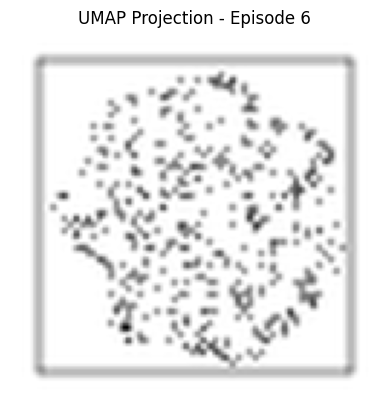

Iteration 6/10, Reward=-0.0028, Diversity=0.9652


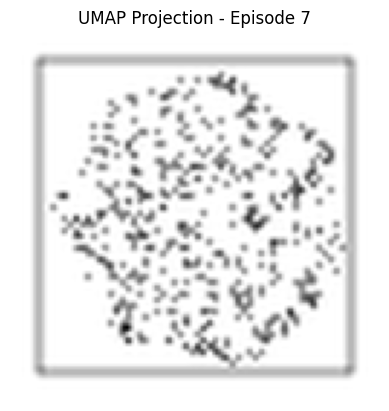

Iteration 7/10, Reward=0.0073, Diversity=0.9861


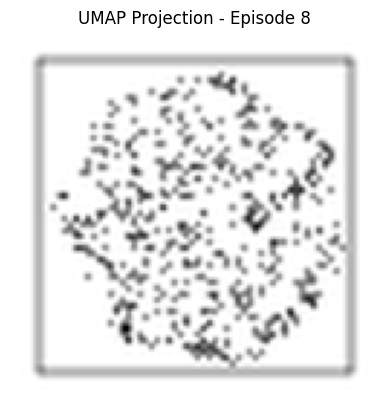

Iteration 8/10, Reward=0.0107, Diversity=0.9868


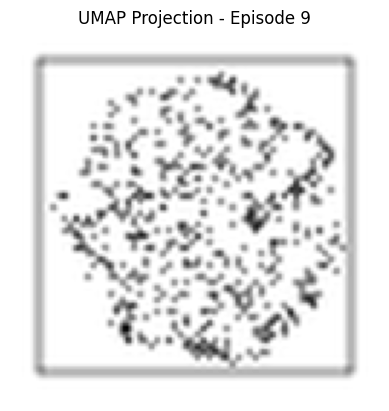

Iteration 9/10, Reward=-0.0040, Diversity=0.9882


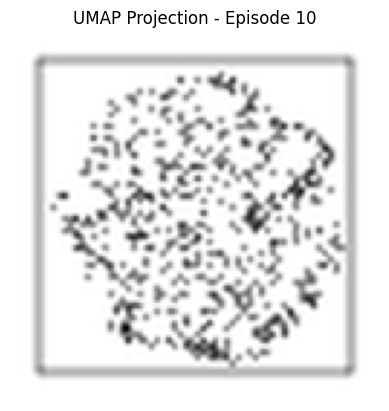

Iteration 10/10, Reward=0.0044, Diversity=0.9876


In [20]:
def main():
    device = 'cpu'
    
    # 1) Khởi tạo dataset ban đầu (toy)
    np.random.seed(42)
    init_dataset = np.random.normal(loc=0, scale=1, size=(200, 5))  # 200 điểm, 5 chiều
    
    # Fit UMAP
    reducer = umap.UMAP(n_neighbors=10, min_dist=0.1, n_components=2, random_state=42)
    reducer.fit(init_dataset)  # Học UMAP
    
    # 2) Khởi tạo policy, value
    z_dim = 5
    policy_net = PolicyNetwork(z_dim=z_dim)
    value_net = ValueNetwork(z_dim=z_dim)
    
    trainer = PPOTrainer(policy_net, value_net, z_dim=z_dim, device=device)
    
    # 3) Vòng lặp training
    dataset = init_dataset
    n_iters = 10
    batch_size = 8
    
    for iter_idx in range(n_iters):
        # Tạo batch z ngẫu nhiên (cũng có thể là z cũ,...)
        z_batch = torch.randn(batch_size, z_dim)

        # Gọi step => PPO update
        mean_reward = trainer.step(dataset, z_batch, reducer)

        # Demo: ta sẽ cập nhật dataset = dataset + reconstruction trung bình
        # Ở phần step() ta có reconstruct_data_batch -> ta sẽ fetch ra
        # Để đơn giản, ta chỉ reconstruct z_batch[0] => add vào dataset
        with torch.no_grad():
            single_image = dataset_to_image_via_umap(dataset, reducer, (64,64))
            single_image = single_image.unsqueeze(0).to(device)
            z_prime = policy_net(single_image, z_batch[0].unsqueeze(0).to(device))
            rec_data = reconstruct_data_from_z(z_prime, n_samples=50)[0]  # shape (50, data_dim)
            dataset = np.concatenate([dataset, rec_data], axis=0)
        
        # Hiển thị ảnh UMAP của dataset sau khi cập nhật
        umap_image = dataset_to_image_via_umap(dataset, reducer, img_size=(128, 128))  # Resize lớn hơn để dễ nhìn
        plt.imshow(umap_image.squeeze(), cmap='gray')
        plt.title(f"UMAP Projection - Episode {iter_idx+1}")
        plt.axis('off')
        plt.show()
        
        print(f"Iteration {iter_idx+1}/{n_iters}, Reward={mean_reward:.4f}, "
              f"Diversity={compute_diversity(dataset):.4f}")


if __name__ == "__main__":
    main()
